## Model Building

In [39]:
#import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
#Read data
df = pd.read_csv('mubawab_listings_eda.csv')

In [4]:
df.head()

,Type,Localisation,Latitude,Longitude,Price,Area,Rooms,Bedrooms,Bathrooms,Floor,Other_tags,Price_m2,Current_state,Age
0,Appartements,Anfa,NaN,NaN,1230000,86.0,3.0,2.0,2.0,1.0,"['Bon état', '10-20 ans']",14302.325581,Bon état,10-20 ans
1,Appartements,La Gironde,NaN,NaN,900000,86.0,3.0,2.0,1.0,5.0,"['Bon état', '10-20 ans']",10465.116279,Bon état,10-20 ans
2,Appartements,Bourgogne Ouest,NaN,NaN,2400000,180.0,5.0,3.0,3.0,3.0,"['Bon état', '10-20 ans']",13333.333333,Bon état,10-20 ans
3,Appartements,Les princesses,33.574209,-7.644182,1550000,120.0,5.0,3.0,2.0,5.0,"['Bon état', '5-10 ans']",12916.666667,Bon état,5-10 ans
4,Appartements,Bourgogne Ouest,NaN,NaN,1450000,113.0,4.0,3.0,2.0,1.0,"['Bon état', '10-20 ans']",12831.858407,Bon état,10-20 ans


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           1250 non-null   object 
 1   Localisation   1250 non-null   object 
 2   Latitude       672 non-null    float64
 3   Longitude      672 non-null    float64
 4   Price          1250 non-null   int64  
 5   Area           1250 non-null   float64
 6   Rooms          1191 non-null   float64
 7   Bedrooms       1247 non-null   float64
 8   Bathrooms      1207 non-null   float64
 9   Floor          953 non-null    float64
 10  Other_tags     1250 non-null   object 
 11  Price_m2       1250 non-null   float64
 12  Current_state  1101 non-null   object 
 13  Age            715 non-null    object 
dtypes: float64(8), int64(1), object(5)
memory usage: 136.8+ KB


In [6]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price']
df_model = df[cols_to_keep]

In [7]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms             59
Bedrooms           3
Bathrooms         43
Floor            297
Current_state    149
Age              535
Price              0
dtype: int64

In [8]:
#drop listings where all four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [75]:
df_model.isna().sum()

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     38
Age              240
Price              0
dtype: int64

In [81]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price'].values 

In [83]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

In [84]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,86.0,3.0,2.0,2.0,1.0,2,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86.0,3.0,2.0,1.0,5.0,2,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180.0,5.0,3.0,3.0,3.0,2,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,120.0,5.0,3.0,2.0,5.0,2,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,113.0,4.0,3.0,2.0,1.0,2,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,103.0,3.0,2.0,2.0,3.0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
883,450.0,5.0,4.0,5.0,0.0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
884,1040.0,8.0,5.0,6.0,0.0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
885,74.0,3.0,2.0,2.0,4.0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [85]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [30]:
#Scale the features using robust_scaler
from sklearn.preprocessing import RobustScaler

In [86]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [179]:
#define function to evaluate linear models
def evaluate_linear_model(X_train,y_train,X_test,y_test,reg):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error = np.sqrt(MSE(y_test,y_pred))

    print(f'RMSE : {RMSE_error:.2f}')
    print(f'Training set score (R^2): {reg.score(X_train,y_train):.2f}')
    print(f'Test set score (R^2): {reg.score(X_test,y_test):.2f}')
    coef_matrix = pd.DataFrame(np.hstack([reg.intercept_,reg.coef_]).reshape(1,-1),columns = np.hstack(['Intercept',X_dummies.columns]))
    display(coef_matrix)
    
    error_matrix = np.array([y_test,y_test-y_pred])

    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = coef_matrix.columns,x = coef_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    

    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    #g = sns.jointplot(x = error_matrix[0,:], y= error_matrix[1,:],color = cust_pal[5], height = 8, ratio = 5)
    
    plt.tight_layout()
    plt.show()

RMSE : 2662565.06
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.298985e+06,11053.389544,-84784.311397,-188929.796151,519362.127698,-22784.708028,-137457.455027,-105286.373834,-971405.136222,971405.136222,...,-523720.085161,-532892.878411,-1.341152e+06,-1.229378e+06,-199784.418136,-3.330259e+06,265033.470113,-1.497651e+06,195207.419647,-361096.554744


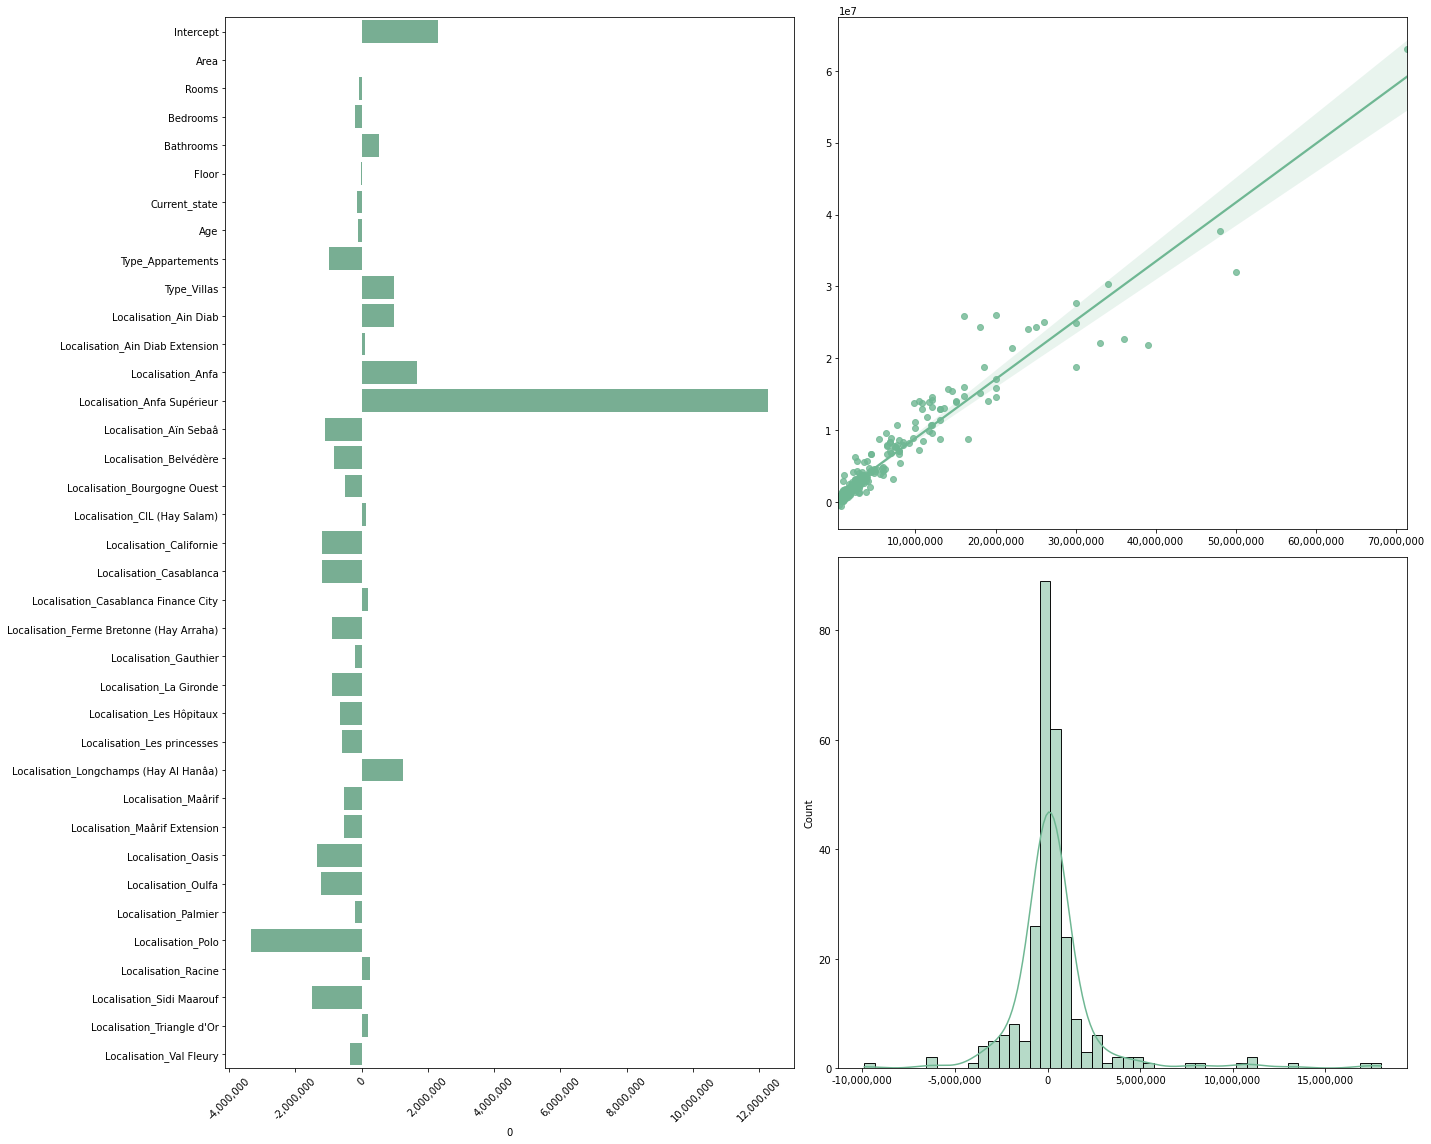

In [180]:
#Evaluate multivariate ols linear regression

cust_pal = sns.color_palette(sns.light_palette('#0d874b',10))
reg = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)

RMSE : 2775086.69
Training set score (R^2): 0.93
Test set score (R^2): 0.90


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.006091e+06,11667.695772,-26918.362302,-277735.699528,472262.80513,-33709.589023,-79523.355814,-103442.809991,-977837.144738,977837.144738,...,-194614.927009,-218982.677536,-828890.065435,-662303.613647,37680.007849,-2.057899e+06,389540.850938,-924901.732928,211785.149868,-90800.178715


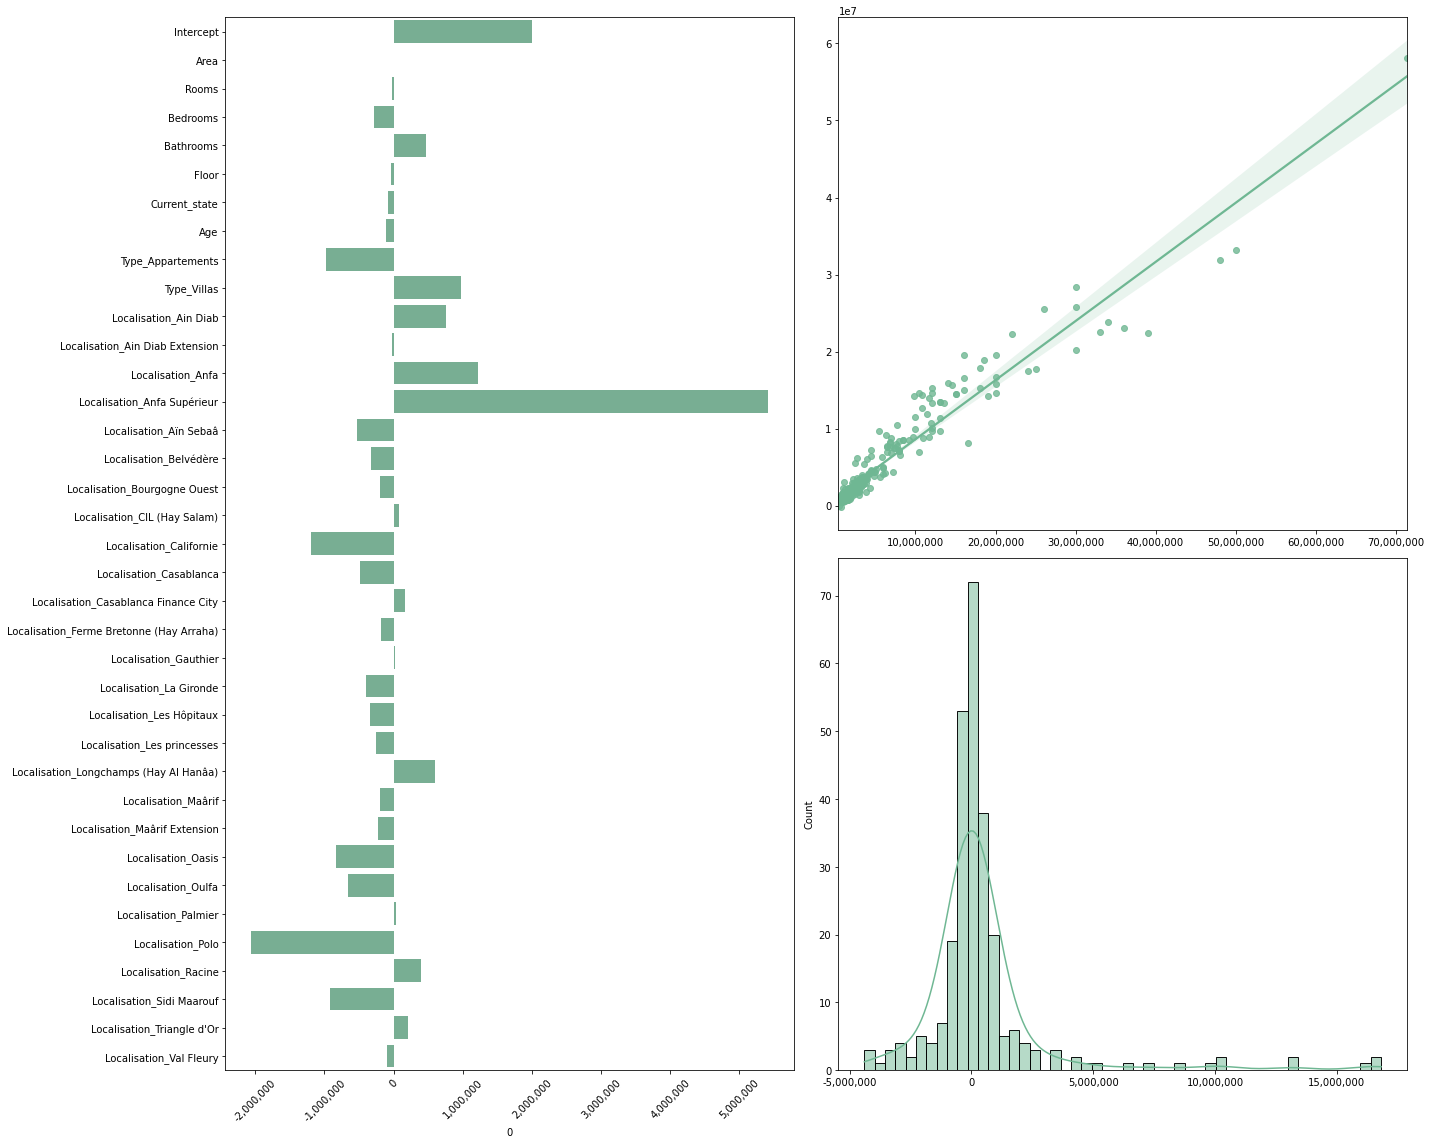

In [182]:
#Use a Ridge regression to introduce regularization
reg = Ridge(alpha = 10)
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)

RMSE : 2779628.33
Training set score (R^2): 0.93
Test set score (R^2): 0.90


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.346058e+06,3.678688e+06,-107412.98261,-501445.824935,472305.783261,-125592.825442,-88681.162263,-377701.401806,-1.000927e+06,1.000927e+06,...,-189518.871311,-212064.218217,-827884.874292,-672051.645134,29602.504635,-2.042246e+06,383936.085657,-957355.502828,206513.158624,-95678.348958


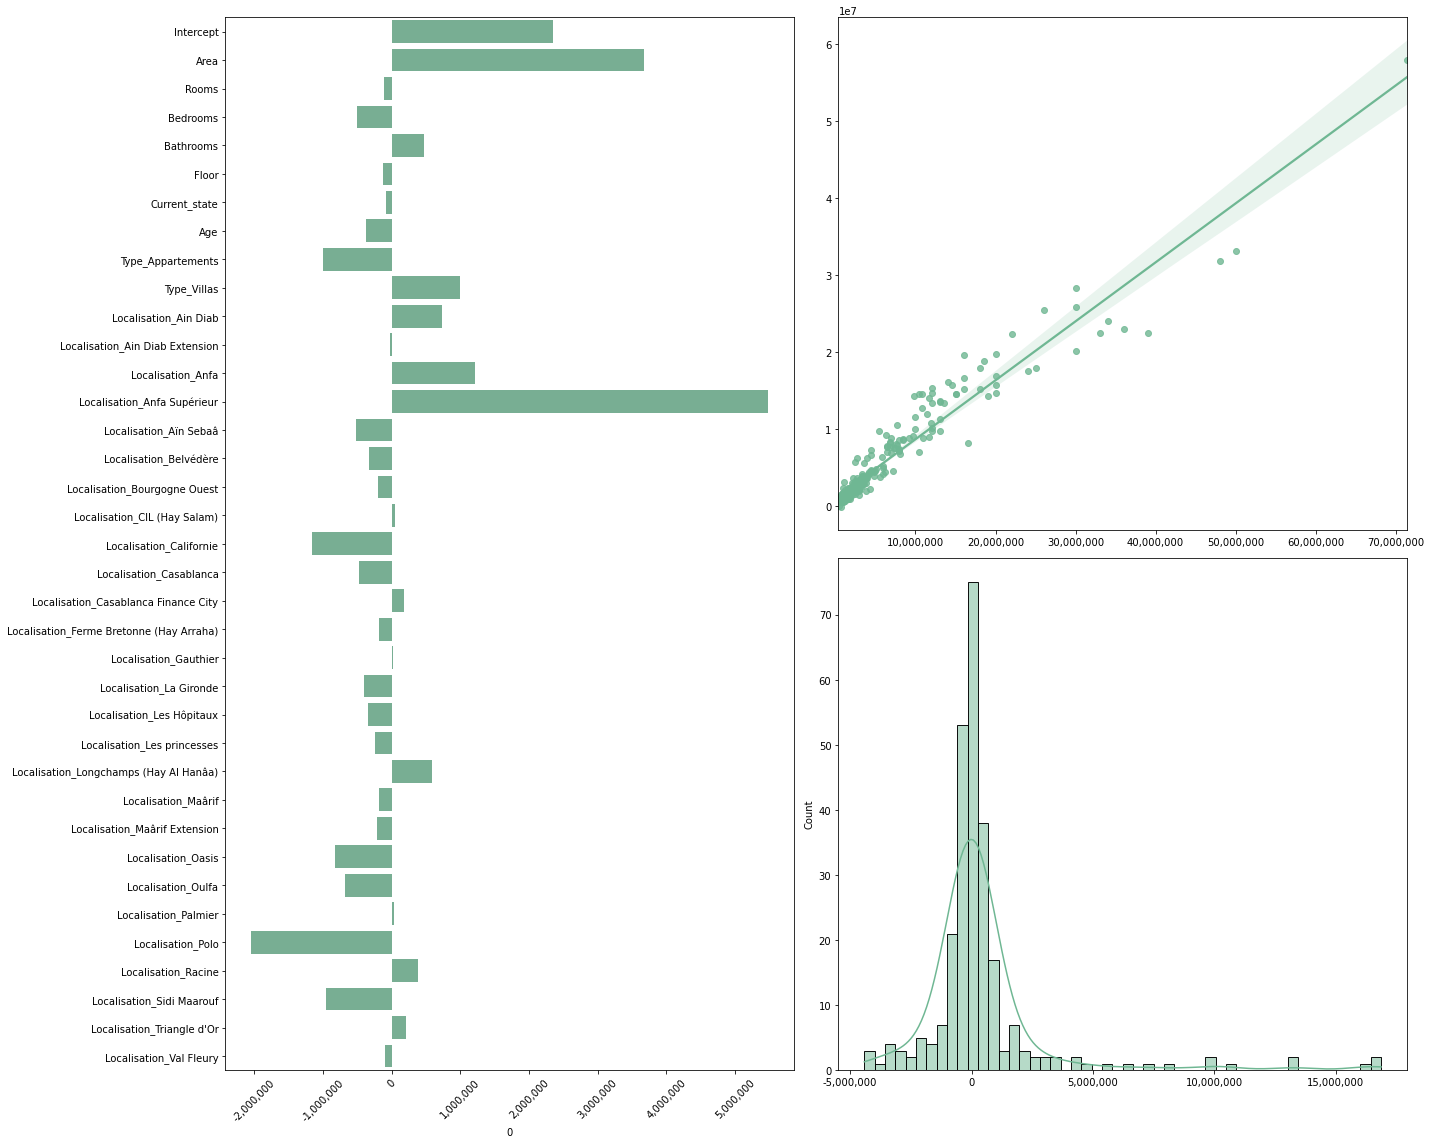

In [185]:
#Use a Ridge regression to introduce regularization with scaled data
reg = Ridge(alpha = 10)
evaluate_linear_model(X_train_scaled,y_train,X_test_scaled,y_test,reg)

In [191]:
def evaluate_tree_model(X_train,y_train,X_test,y_test,reg):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error = np.sqrt(MSE(y_test,y_pred))

    print(f'RMSE : {RMSE_error:.2f}')
    print(f'Training set score: {reg.score(X_train,y_train):.2f}')
    print(f'Test set score: {reg.score(X_test,y_test):.2f}')
    importances_matrix = pd.DataFrame(reg.feature_importances_.reshape(1,-1),columns = X_dummies.columns)
    display(importances_matrix)
    error_matrix = np.array([y_test,y_test-y_pred])
    
    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = importances_matrix.columns,x = importances_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    
    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    plt.tight_layout()
    plt.show()

In [101]:
from sklearn.ensemble import RandomForestRegressor

RMSE : 2657923.46
Training set score: 0.99
Test set score: 0.91


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.568377,0.02845,0.035862,0.028458,0.083864,0.012162,0.011326,0.078196,0.076616,0.003245,...,0.000046,0.000026,0.000751,0.001002,0.000033,0.002736,0.000526,0.006123,0.00012,0.000012


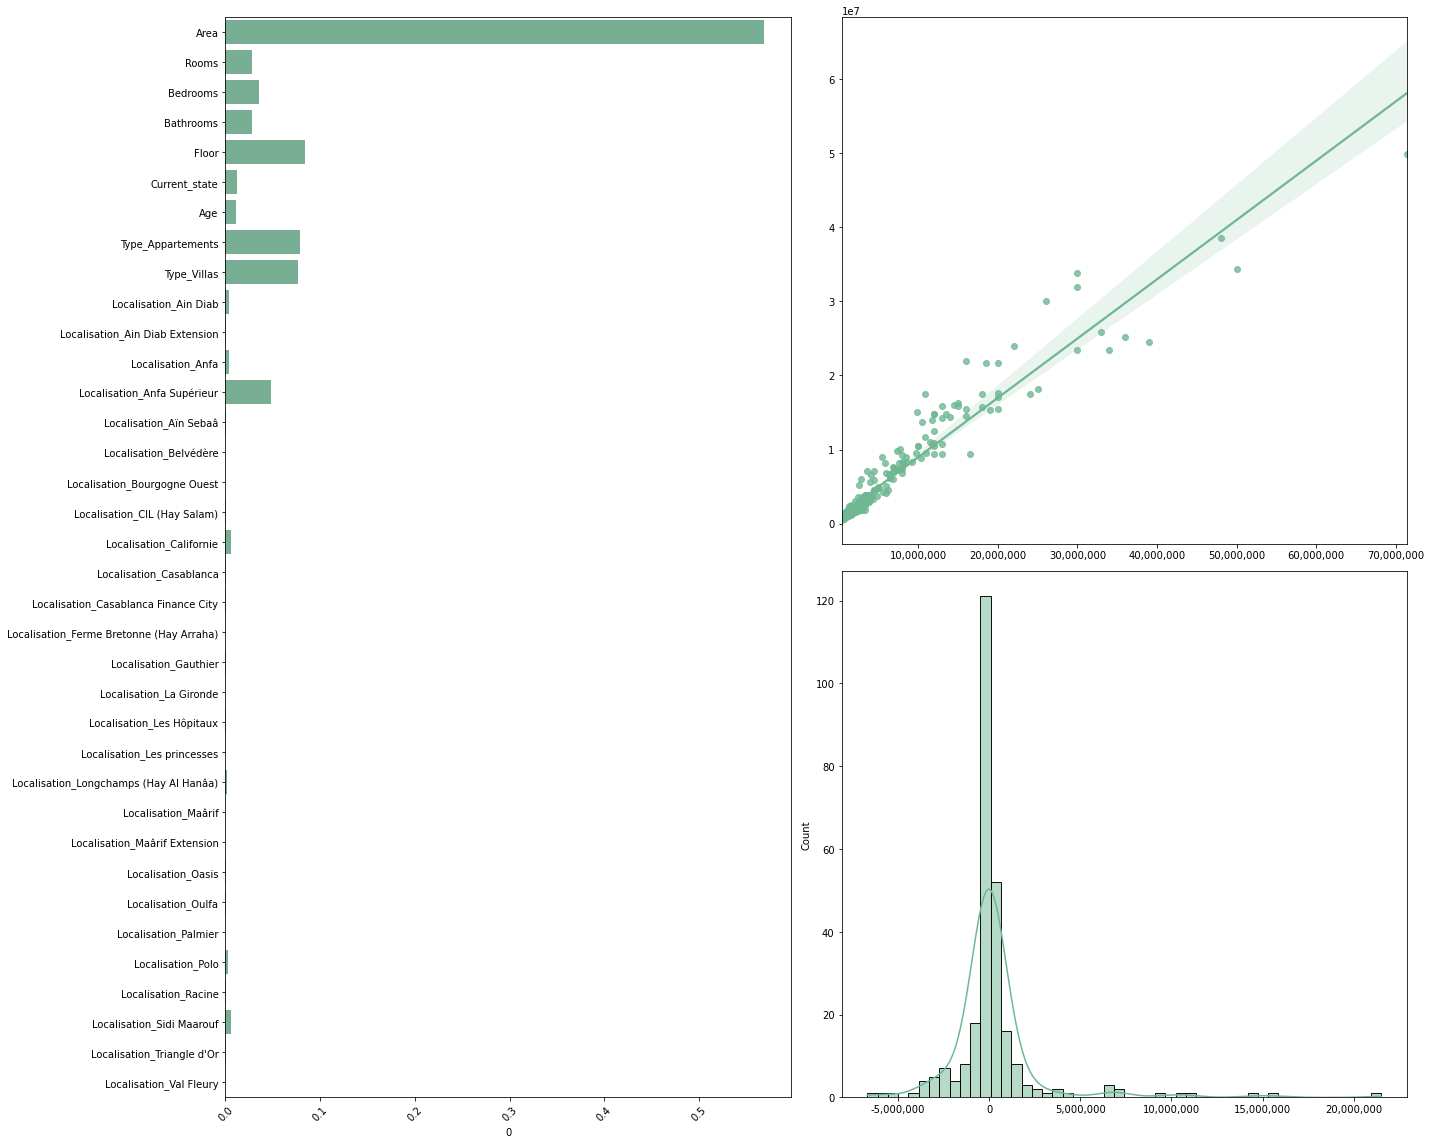

In [192]:
#Use a random forest regressor
reg = RandomForestRegressor(n_estimators=250,random_state=0,max_features = 15)

evaluate_tree_model(X_train,y_train,X_test,y_test,reg)

In [107]:
reg.feature_importances_

array([9.28577313e-01, 9.70927765e-03, 6.85467681e-03, 9.71363493e-03,
       8.56724733e-04, 1.04751441e-02, 7.05994365e-03, 4.73992427e-04,
       4.56168286e-04, 2.95634704e-03, 3.66909659e-04, 3.47179782e-03,
       9.01864993e-03, 6.11130813e-05, 4.47325683e-05, 3.02780976e-05,
       6.87278652e-04, 2.17145355e-03, 1.99718363e-04, 1.11565348e-04,
       6.43474622e-06, 1.78938273e-04, 3.56578065e-05, 1.77951568e-04,
       4.32786009e-05, 8.77326655e-04, 5.48025247e-05, 2.21371567e-05,
       4.01874366e-04, 3.53223902e-04, 3.36701356e-05, 3.84816311e-03,
       3.13675613e-04, 2.83953566e-04, 5.95828944e-05, 1.26088793e-05])